In [20]:
import numpy as np
import matplotlib.pyplot as plt
from poles_roots.aaa import AAA
from poles_roots._utils import linspace_on_tri, convert_cart_to_complex

For now we only consider right triangle of different sizes.

In [51]:
side_length = 3

points = np.array([[0,0], [side_length, 0], [0, side_length]])

def linspace_in_right_triangle(num, side_length):
    tmp = np.linspace(0, side_length, num=int(num**0.5))
    [xx, yy] = np.meshgrid(tmp, tmp)
    mask = xx + yy > 1
    xx = xx[~mask]
    yy = yy[~mask]
    return xx.ravel(), yy.ravel()

In [60]:
rng = np.random.default_rng()
difference = []

for _ in range(1000):
    # generate random pole
    r_pole = rng.uniform(0, side_length)
    im_pole = rng.uniform(0, side_length)
    if r_pole + im_pole > side_length:
        r_pole = side_length - r_pole
        im_pole = side_length - im_pole
    # of random order
    order = rng.integers(1, 15)
    
    def f(z):
        return 1/(z-(r_pole+im_pole*1j))**order
    
    x, y = linspace_in_right_triangle(2000, side_length)
    Z_in = x+y*1j
    F_in = f(Z_in)
    
    n_actual = x.size
    
    Z = convert_cart_to_complex(linspace_on_tri(points, n_actual))
    F = f(Z)
    
    res_in = AAA(F_in, Z_in)
    res = AAA(F, Z)
    
    difference.append(res.weights.size - res_in.weights.size)

/home/jakeb/development/poles-and-roots/src/poles_roots/aaa.py:197: RuntimeWarning: divide by zero encountered in divide
  N = (1 / (pol[:, np.newaxis] - zj)) @ (fj * wj)
/home/jakeb/development/poles-and-roots/src/poles_roots/aaa.py:197: RuntimeWarning: invalid value encountered in divide
  N = (1 / (pol[:, np.newaxis] - zj)) @ (fj * wj)
/home/jakeb/development/poles-and-roots/src/poles_roots/aaa.py:198: RuntimeWarning: divide by zero encountered in divide
  Ddiff = -((1 / np.subtract.outer(pol, zj)) ** 2) @ wj
/home/jakeb/development/poles-and-roots/src/poles_roots/aaa.py:198: RuntimeWarning: invalid value encountered in divide
  Ddiff = -((1 / np.subtract.outer(pol, zj)) ** 2) @ wj
/home/jakeb/development/poles-and-roots/src/poles_roots/aaa.py:199: RuntimeWarning: invalid value encountered in divide
  res = N / Ddiff
/home/jakeb/development/poles-and-roots/src/poles_roots/aaa.py:227: RuntimeWarning: invalid value encountered in divide
  ii = np.nonzero(np.abs(res) / Z_distances < cl

Text(0.5, 1.0, 'Side length=3')

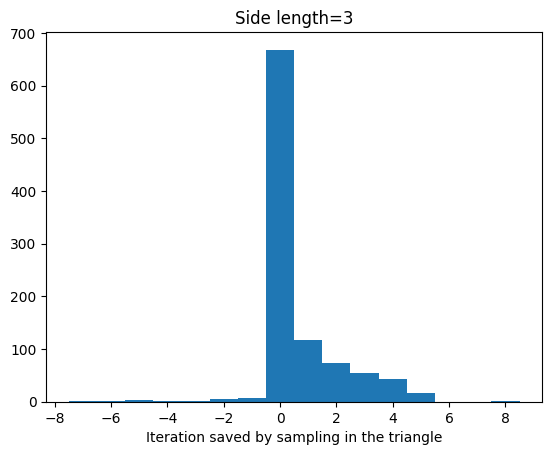

In [61]:
plt.hist(difference, align="left", bins=range(min(difference), max(difference) + 1, 1))
plt.xlabel("Iteration saved by sampling in the triangle")
plt.title(f"Side length={side_length}")